In [43]:
import numpy as np
import heapq
from operator import itemgetter
from analysis_toolkit import res_extractor, draw_graph
from qiskit import  transpile
from qiskit_aer import AerSimulator
from hamiltonian import hamiltonian_para
from data_score import Generate_Data
from qannealing import annealing

0 2
1 4
3 5
[0, 1, 1, 1, 0, 0] [1, 0, 0] [0, 0, 0, 1, 0, 0] True True False


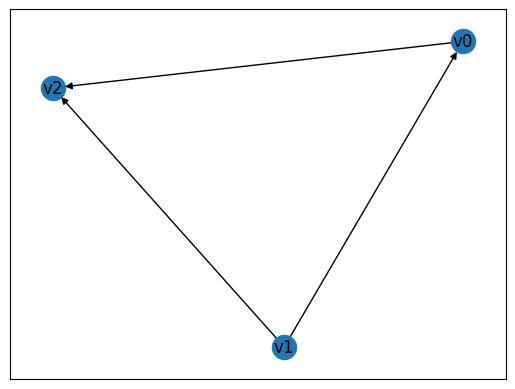

In [41]:
def QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 100, delta_cons = 120, delta_trans = 100, shots = 3000):
    D = Generate_Data(n)

    C, h, J = hamiltonian_para(n, m, D, delta_max, \
                           delta_cons, delta_trans)

    circ = annealing(n, M, h, J, T, lamda)
    simulator = AerSimulator()
    compiled_circuit = transpile(circ, simulator)
    job = simulator.run(compiled_circuit, shots = shots)
    res = job.result()
    counts = res.get_counts(compiled_circuit)
    return counts

# examples of the usage of toolkit
n = 2
m = 1
tmp = '0100110'

n = 3
m = 1
tmp = '110111110110001'

d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
print(d, r, y, is_cons, is_dag, is_legal)
draw_graph(G)


In [42]:
n = 2
m = 1

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 90, delta_cons = 90, delta_trans = 90)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(d,r,y, is_cons, is_dag, is_legal)

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 100, delta_cons = 90, delta_trans = 90)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(d,r,y, is_cons, is_dag, is_legal)

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 90, delta_cons = 120, delta_trans = 90)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(d,r,y, is_cons, is_dag, is_legal)

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 90, delta_cons = 90, delta_trans = 120)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(d,r,y, is_cons, is_dag, is_legal)


Before spin transformation: 90*d[0, 1]*r[0, 0] + 180*d[0, 1]*y[1, 0] + 360*d[0, 1]*y[1, 1] - 130.883406347138*d[0, 1] - 90*d[1, 0]*r[0, 0] + 180*d[1, 0]*y[0, 0] + 360*d[1, 0]*y[0, 1] - 41.1270588651738*d[1, 0] + 360*y[0, 0]*y[0, 1] - 90*y[0, 0] + 360*y[1, 0]*y[1, 1] - 90*y[1, 0] + 221.005232606156


100%|█████████████████████████████████████████████| 128/128 [00:00<00:00, 673.59it/s]

Brute force results: {'0100110': -0.12182625901786537, '0001001': 0.12182625901789379, '0101000': 41.005232606155914, '0101100': 41.005232606155914, '0000011': 48.994767393844114}


0 1
[0, 0] [0] [1, 0, 1, 0] True True True
0 1
[0, 0] [1] [1, 0, 1, 0] True True True
0 1
[1, 0] [0] [1, 0, 0, 0] True True True
0 1
[1, 1] [0] [0, 0, 0, 0] False True False
0 1
[0, 1] [1] [0, 0, 1, 0] True True True
Before spin transformation: 90*d[0, 1]*r[0, 0] + 200*d[0, 1]*y[1, 0] + 400*d[0, 1]*y[1, 1] - 135.263045279645*d[0, 1] - 90*d[1, 0]*r[0, 0] + 200*d[1, 0]*y[0, 0] + 400*d[1, 0]*y[0, 1] - 45.6568883371134*d[1, 0] + 400*y[0, 0]*y[0, 1] - 100*y[0, 0] + 400*y[1, 0]*y[1, 1] - 100*y[1, 0] + 235.459966808379


100%|█████████████████████████████████████████████| 128/128 [00:00<00:00, 360.06it/s]


Brute force results: {'0100110': -0.19692152873432178, '0001001': 0.1969215287343502, '0101000': 35.45996680837908, '0101100': 35.45996680837908, '0000011': 54.54003319162095}
0 1
[1, 1] [0] [0, 1, 0, 1] False True False
0 1
[1, 1] [1] [0, 1, 0, 1] False True False
0 1
[0, 0] [1] [0, 1, 1, 1] True True False
0 1
[0, 0] [0] [1, 1, 0, 1] True True False
0 1
[0, 1] [1] [0, 1, 1, 1] True True False
Before spin transformation: 120*d[0, 1]*r[0, 0] + 180*d[0, 1]*y[1, 0] + 360*d[0, 1]*y[1, 1] - 127.578042814481*d[0, 1] - 120*d[1, 0]*r[0, 0] + 180*d[1, 0]*y[0, 0] + 360*d[1, 0]*y[0, 1] - 7.93908189474487*d[1, 0] + 360*y[0, 0]*y[0, 1] - 90*y[0, 0] + 360*y[1, 0]*y[1, 1] - 90*y[1, 0] + 217.758562354613


100%|█████████████████████████████████████████████| 128/128 [00:00<00:00, 661.83it/s]

Brute force results: {'0100110': -0.1805195401318258, '0001001': 0.18051954013179738, '0101000': 37.75856235461305, '0101100': 37.75856235461305, '0000011': 82.24143764538692}


0 1
[0, 1] [1] [0, 0, 1, 0] True True True
0 1
[1, 0] [0] [1, 0, 0, 0] True True True
0 1
[0, 0] [1] [1, 0, 1, 0] True True True
0 1
[0, 0] [0] [1, 0, 1, 0] True True True
0 1
[0, 1] [0] [0, 0, 1, 0] False True True
Before spin transformation: 90*d[0, 1]*r[0, 0] + 180*d[0, 1]*y[1, 0] + 360*d[0, 1]*y[1, 1] - 132.501911890749*d[0, 1] - 90*d[1, 0]*r[0, 0] + 180*d[1, 0]*y[0, 0] + 360*d[1, 0]*y[0, 1] - 42.6869558259779*d[1, 0] + 360*y[0, 0]*y[0, 1] - 90*y[0, 0] + 360*y[1, 0]*y[1, 1] - 90*y[1, 0] + 222.594433858364


100%|█████████████████████████████████████████████| 128/128 [00:00<00:00, 689.55it/s]

Brute force results: {'0100110': -0.09252196761437403, '0001001': 0.09252196761437403, '0101000': 42.594433858363544, '0101100': 42.594433858363544, '0000011': 47.405566141636456}


0 1
[0, 1] [1] [0, 0, 1, 0] True True True
0 1
[0, 0] [1] [1, 0, 1, 0] True True True
0 1
[0, 0] [0] [1, 0, 1, 0] True True True
0 1
[1, 1] [0] [0, 0, 0, 0] False True False
0 1
[1, 0] [0] [1, 0, 0, 0] True True True


Before spin transformation: 90*d[0, 1]*r[0, 0] + 180*d[0, 1]*y[1, 0] + 360*d[0, 1]*y[1, 1] - 133.470225071627*d[0, 1] - 90*d[1, 0]*r[0, 0] + 180*d[1, 0]*y[0, 0] + 360*d[1, 0]*y[0, 1] - 43.7253452299416*d[1, 0] + 360*y[0, 0]*y[0, 1] - 90*y[0, 0] + 360*y[1, 0]*y[1, 1] - 90*y[1, 0] + 223.597785150784


100%|█████████████████████████████████████████████| 128/128 [00:00<00:00, 718.83it/s]

Brute force results: {'0100110': -0.12756007915714918, '0001001': 0.1275600791571776, '0101000': 43.597785150784404, '0101100': 43.597785150784404, '0000011': 46.402214849215625}


0 1
[1, 0] [0] [1, 0, 0, 0] True True True
0 1
[0, 1] [1] [0, 0, 1, 0] True True True
0 1
[0, 0] [1] [1, 0, 1, 0] True True True
0 1
[0, 0] [0] [1, 0, 1, 0] True True True
0 1
[1, 1] [0] [0, 0, 0, 0] False True False


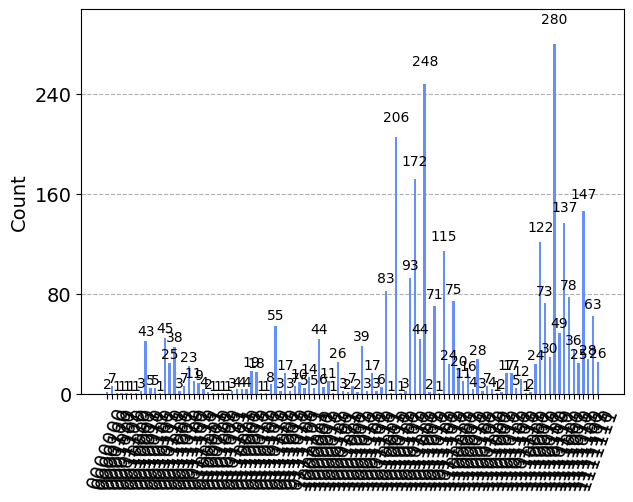

In [37]:
from qiskit.visualization import array_to_latex, plot_histogram
counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 90, delta_cons = 90, delta_trans = 90)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(d,r,y, is_cons, is_dag, is_legal)
plot_histogram(counts)

1110110
0 1
[1, 0] [0] [1, 0, 0, 0] True True True


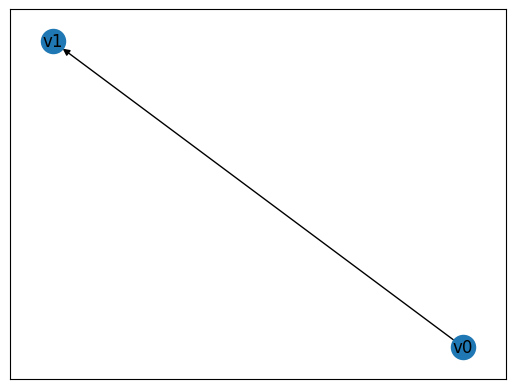

In [38]:
ans = max(best_counts, key = lambda k: best_counts[k])
print(ans)
d, r, y, G, is_cons, is_dag, is_legal = res_extractor(ans, n, m)
print(d, r, y, is_cons, is_dag, is_legal)
draw_graph(G)

In [39]:
n = 3
m = 1

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 90, delta_cons = 90, delta_trans = 90)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(d,r,y, is_cons, is_dag, is_legal)

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 100, delta_cons = 90, delta_trans = 90)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(d,r,y, is_cons, is_dag, is_legal)

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 90, delta_cons = 120, delta_trans = 90)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(d,r,y, is_cons, is_dag, is_legal)

counts = QA4BNSL(n, m, M = 100, T = 10, lamda = 1, delta_max = 90, delta_cons = 90, delta_trans = 120)
best_counts = dict(heapq.nlargest(5, counts.items(),key=itemgetter(1)))
for tmp in best_counts:
    d, r, y, G, is_cons, is_dag, is_legal = res_extractor(tmp, n, m)
    print(d,r,y, is_cons, is_dag, is_legal)


Before spin transformation: 180*d[0, 1]*d[2, 1] + 90*d[0, 1]*r[0, 0] + 180*d[0, 1]*y[1, 0] + 360*d[0, 1]*y[1, 1] - 189.612823004503*d[0, 1] + 180*d[0, 2]*d[1, 2] + 90*d[0, 2]*r[1, 0] + 180*d[0, 2]*y[2, 0] + 360*d[0, 2]*y[2, 1] - 266.978948726707*d[0, 2] + 180*d[1, 0]*d[2, 0] - 90*d[1, 0]*r[0, 0] + 180*d[1, 0]*y[0, 0] + 360*d[1, 0]*y[0, 1] - 60.9638242000968*d[1, 0] + 90*d[1, 2]*r[2, 0] + 180*d[1, 2]*y[2, 0] + 360*d[1, 2]*y[2, 1] - 178.157606805426*d[1, 2] - 90*d[2, 0]*r[1, 0] + 180*d[2, 0]*y[0, 0] + 360*d[2, 0]*y[0, 1] - 144.495767149539*d[2, 0] - 90*d[2, 1]*r[2, 0] + 180*d[2, 1]*y[1, 0] + 360*d[2, 1]*y[1, 1] - 94.3234240326658*d[2, 1] - 90*r[0, 0]*r[1, 0] + 90*r[0, 0]*r[2, 0] - 90*r[1, 0]*r[2, 0] + 90*r[1, 0] + 360*y[0, 0]*y[0, 1] - 90*y[0, 0] + 360*y[1, 0]*y[1, 1] - 90*y[1, 0] + 360*y[2, 0]*y[2, 1] - 90*y[2, 0] + 602.266196959469


 44%|█████████████████▉                       | 14383/32768 [02:21<03:01, 101.37it/s]


KeyboardInterrupt: 